# Resources: 
https://debuggercafe.com/transfer-learning-with-pytorch/ 


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
!pip install wandb
import wandb
wandb.init()

#Import

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
import torch
# Import torch.nn which contains all functions necessary to define a convolutional neural network
import torch.nn as nn
import sys
import os
# Generate confusion matrixes
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard.writer import SummaryWriter
import torchvision.models as models
import pandas as pd
# import socket
# import time
# import os
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.nn.parallel import DataParallel

from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import auc, roc_curve, confusion_matrix


# # Generate summary statistics
# from sklearn.metrics import summary_statistics

# Data Path

**Paths to (only resized) non-nomalized datasets**

In [ ]:
# Jimin's paths below 
training = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-train'
validation = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-val'
test = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-test'
# training = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-train-tiny'
# validation = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-val-tiny'
# test = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-test-tiny'


# Xinran's paths below
# training = '/content/gdrive/MyDrive/GT/cs4641/dataset/preprocessed-train'
# validation = '/content/gdrive/MyDrive/GT/cs4641/dataset/preprocessed-val'
# test = '/content/gdrive/MyDrive/GT/cs4641/dataset/preprocessed-test'

# train: 40 images, validation: 10 images, test: 10 images 
# training = '/content/gdrive/MyDrive/GT/cs4641/dataset/preprocessed-train-tiny'
# validation = '/content/gdrive/MyDrive/GT/cs4641/dataset/preprocessed-val-tiny'
# test = '/content/gdrive/MyDrive/GT/cs4641/dataset/preprocessed-test-tiny'


# Danni's paths below
# training = '/content/gdrive/MyDrive/cs4641/dataset/preprocessed-train'
# validation = '/content/gdrive/MyDrive/cs4641/dataset/preprocessed-val'
# test = '/content/gdrive/MyDrive/cs4641/dataset/preprocessed-test'


print(len(os.listdir(training)))
print(len(os.listdir(validation)))
print(len(os.listdir(test)))

2800
700
500


In [ ]:
import pandas as pd
# Jimin's paths below 
train_val_label_csv = '/content/gdrive/MyDrive/CS4641_dataset/sample_train.xlsx'

# Xinran's paths below
# train_val_label_csv = '/content/gdrive/MyDrive/GT/cs4641/sample_train.xlsx'

# Danni's paths below
# train_val_label_csv = '/content/gdrive/MyDrive/cs4641/sample_train.xlsx'

train_val_label = pd.read_excel(train_val_label_csv)
train_val_filelist = train_val_label['file_name'].tolist()
train_val_labellist = train_val_label['class'].tolist()

print(len(train_val_filelist), len(train_val_labellist))

3500 3500


In [ ]:
# Jimin's paths below 
tests_label_csv = '/content/gdrive/MyDrive/CS4641_dataset/sample_test.xlsx'

# Xinran's paths below
# tests_label_csv = '/content/gdrive/MyDrive/GT/cs4641/sample_test.xlsx'

# Danni's paths below
# tests_label_csv = '/content/gdrive/MyDrive/cs4641/sample_test.xlsx'

test_label = pd.read_excel(tests_label_csv)
test_filelist = test_label['file_name'].tolist()
test_labellist = test_label['class'].tolist()

print(len(test_filelist), len(test_labellist))

500 500


In [ ]:
training_jpeg = os.listdir(training)
validation_jpeg = os.listdir(validation)
test_jpeg = os.listdir(test)
print(len(training_jpeg))
print(len(validation_jpeg))
print(len(test_jpeg))


2800
700
500


In [ ]:
train_label = []
for jpeg in training_jpeg:
  for i in range(len(train_val_filelist)):
    if train_val_filelist[i] == jpeg[:-5]: 
      train_label.append(train_val_labellist[i])
print(len(training_jpeg))
print(len(train_label))

print(training_jpeg[:5])
print(train_label[:5])

2800
2800
['34822_left.jpeg', '31073_left.jpeg', '32726_left.jpeg', '42953_left.jpeg', '17604_right.jpeg']
[2, 2, 3, 2, 2]


In [ ]:
valid_label = []
for jpeg in validation_jpeg:
  for i in range(len(train_val_filelist)):
    if train_val_filelist[i] == jpeg[:-5]: 
      valid_label.append(train_val_labellist[i])
print(len(validation_jpeg))
print(len(valid_label))

print(validation_jpeg[:5])
print(valid_label[:5])

700
700
['37688_right.jpeg', '33049_left.jpeg', '37459_right.jpeg', '15652_left.jpeg', '2435_right.jpeg']
[0, 0, 0, 0, 0]


In [ ]:
test_label = []
for jpeg in test_jpeg:
  for i in range(len(test_filelist)):
    if test_filelist[i] == jpeg[:-5]: 
      test_label.append(test_labellist[i])
print(len(test_jpeg))
print(len(test_label))

print(test_jpeg[:5])
print(test_label[:5])

500
500
['37108_right.jpeg', '28308_right.jpeg', '32309_right.jpeg', '43108_left.jpeg', '42342_right.jpeg']
[0, 0, 0, 0, 0]


**Variables**
- training_jpeg and train_label (2800)
- validation_jpeg and valid_label (700)
- test_jpeg and test_label (500)

- _jpeg : array of texts, for example: ['37108_right.jpeg', '28308_right.jpeg', '32309_right.jpeg', '43108_left.jpeg', '42342_right.jpeg' ...]
- _label: array of labels, for example: [0,0,0,0,0 ...]

*This should be same for both preprocessed and preprocessed + normalized dataset*

# Define DataLoaders

In [ ]:
from torch.utils.data import DataLoader,Dataset
import torch
import torchvision

class ImageDataset(Dataset):
    def __init__(self,image_names,image_labels, path):
        self.image_names = image_names
        self.labels = image_labels
        self.path = path
    
    def __len__(self):
        return len(self.image_names)
   
    def __getitem__(self,index):
        image_path = self.path + '/' + self.image_names[index]
        image = cv2.imread(image_path)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        image = np.transpose(image)
        label = self.labels[index]
        sample = {'image': image,'label':label}
        return sample

In [ ]:
# paths to images 
print(training)
print(validation)
print(test)

# initialize ImageDataset instances 
batch_size = 50 # ie 3 images per batch; change this later; set to 3 now for debug purposes 
train_dataset = ImageDataset(training_jpeg, train_label, training)
valid_dataset = ImageDataset(validation_jpeg, valid_label, validation)
test_dataset = ImageDataset(test_jpeg, test_label, test)

# construct DataLoader instances 
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=True
)

/content/gdrive/MyDrive/CS4641_dataset/preprocessed-train
/content/gdrive/MyDrive/CS4641_dataset/preprocessed-val
/content/gdrive/MyDrive/CS4641_dataset/preprocessed-test


**Visualize images in the first 2 batches of training**

26113_right.jpeg
26113_right.jpeg


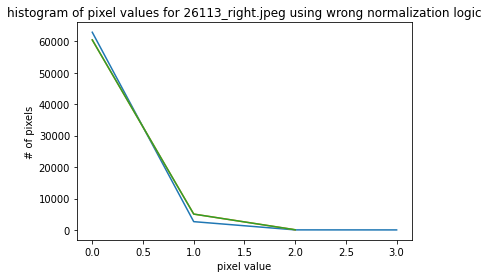

In [ ]:
training_norm = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed_norm_train'
training = '/content/gdrive/MyDrive/CS4641_dataset/preprocessed-train'
norm=os.listdir(training_norm)[11]
train=os.listdir(training)[11]
print(norm)
print(train)
imgnorm=cv2.imread(os.path.join(training_norm,norm))

unique1, counts1 = np.unique(imgnorm[:,:,0], return_counts=True)
unique2, counts2 = np.unique(imgnorm[:,:,1], return_counts=True)
unique3, counts3 = np.unique(imgnorm[:,:,2], return_counts=True)
plt.plot(unique1, counts1, label = 'channel 0')
plt.plot(unique2, counts2, label = 'channel 0')
plt.plot(unique2, counts2, label = 'channel 0')
plt.ylabel("# of pixels")
plt.xlabel("pixel value")
plt.title("histogram of pixel values for 26113_right.jpeg using wrong normalization logic")
plt.show()


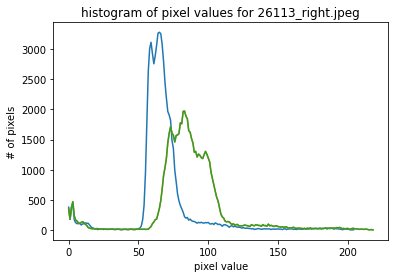

In [ ]:
image = cv2.imread(os.path.join(training,train))
# image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
unique1, counts1 = np.unique(image[:,:,0], return_counts=True)
unique2, counts2 = np.unique(image[:,:,1], return_counts=True)
unique3, counts3 = np.unique(image[:,:,2], return_counts=True)
plt.plot(unique1, counts1, label = 'channel 0')
plt.plot(unique2, counts2, label = 'channel 0')
plt.plot(unique2, counts2, label = 'channel 0')
plt.ylabel("# of pixels")
plt.xlabel("pixel value")
plt.title("histogram of pixel values for 26113_right.jpeg")

plt.show()

Images in batch 0


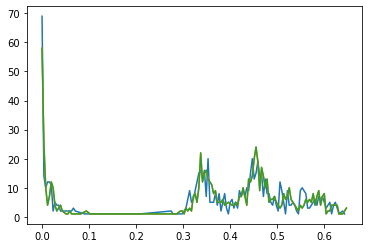

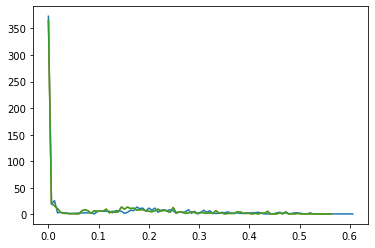

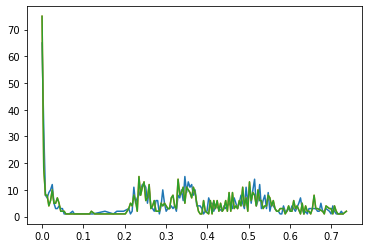

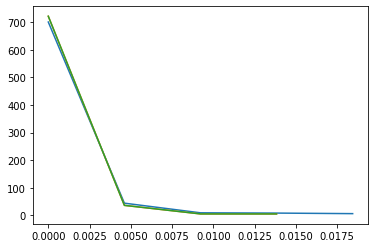

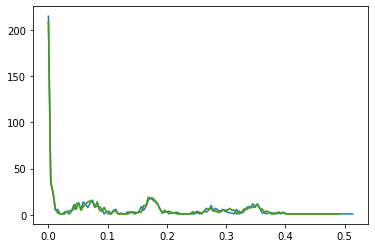

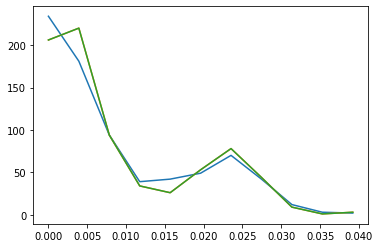

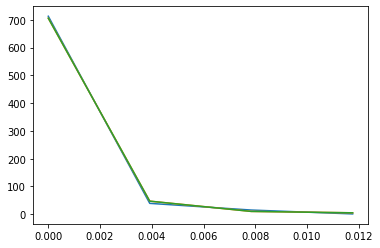

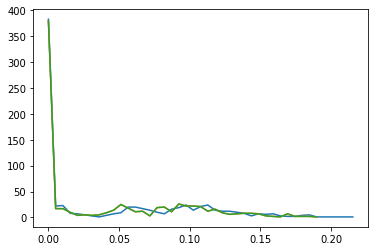

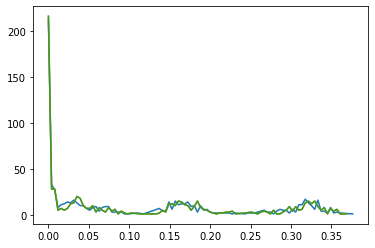

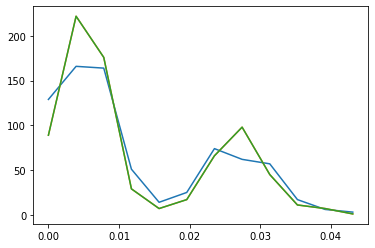

In [ ]:
counter = 1 
import matplotlib.pyplot as plt
for (idx, batch) in enumerate(train_dataloader):
    print('Images in batch', idx)
    i = 0
    for img in batch['image']:
        # plt.imshow(img.T)
        # plt.show()
        # unique1, counts1 = np.unique(img[:,:,0], return_counts=True)
        # unique2, counts2 = np.unique(img[:,:,1], return_counts=True)
        # unique3, counts3 = np.unique(img[:,:,2], return_counts=True)
        # plt.plot(unique1, counts1, label = 'channel 0')
        # plt.plot(unique2, counts2, label = 'channel 0')
        # plt.plot(unique2, counts2, label = 'channel 0')
        # plt.show()
        # print('Class', batch['label'][i])
        # print(np.shape(img))
    
    counter += 1
    if counter > 2: 
        break 

# Initialize the pre-trained model from torchvision.models

In [ ]:
import torchvision
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

## Model definition and loading
# Initialize a pre-trained VGG16 object will 
# download its weights to a cache directory.
vgg16_model = torchvision.models.vgg16(pretrained=True)
vgg16_model.eval() # see the pipeline of pre-trained VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#Modify the pre-trained model to fit our project
1.   Freeze the training layer since pre-trained model already has great ability to  extract generic features
2.   Change the "out_features" from 1,000 to 5 since we have 5 classes to classify



In [ ]:
import torch.nn as nn

# Freeze training for all layers
# To save computation time and that the network would already 
# be able to extract generic features from the dataset.
for param in vgg16_model.features.parameters():
    param.requires_grad = False  

# https://androidkt.com/pytorch-freeze-layer-fixed-feature-extractor-transfer-learning/
# Remove the original fully-connected layer (the last layer) and create a new one
# Newly created modules have requires_grad=True by default
num_features = vgg16_model.classifier[-1].in_features
classifier_layers = list(vgg16_model.classifier.children())[:-1] # Remove the last layer
classifier_layers.extend([nn.Linear(in_features = num_features, out_features=5)]) # Add the new layer with outputting 5 categories
vgg16_model.classifier = nn.Sequential(*classifier_layers) # Replace the model classifier, Overwriting the original


# Define a class for loading the preprocessed data into the modified pre-trained model 

Input parameters: model type, train_dataloader, test_dataloader, criterion, and optimizer 

Outputs: running loss, accuracy


In [ ]:
# customized metric
def average_distance(all_labels, epoch_preds):
    # assuming they are 1D np arrays 
    diff = all_labels - epoch_preds
    abs = np.absolute(diff)
    return np.mean(abs) 

In [ ]:
"""
A class for loading the preprocessed data into a pre-trained model and start training and testing.
"""

# pylint: disable=relative-beyond-top-level

import torch
# Import torch.nn which contains all functions necessary to define a convolutional neural network
import torch.nn as nn
import sys

# Generate confusion matrixes
from sklearn.metrics import confusion_matrix

# Generate summary statistics
# from .metrics import summary_statistics

class multiclass_VGG16_transfer_learning():
    """
    Parameters
    ----------
    model:                The pre-trained model that is already initialized.
    train_dataloader:     A already defined Python iterable over the training dataset.
    test_dataloader:      A already defined Python iterable over the testing dataset.
    criterion:            The loss function used for training the model.
    optimizer:            The optimizer used for training the model.
    
    Output
    ------
    running loss:         The running loss when training the model.
    accuracy:             The accuracy of the trained model.
    """

    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, criterion, optimizer,
                 device = None, writer = None, verbose = False):

        # Auto-select device if none provided.
        # if not device:
        #     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # Set if class closed.
        self.closed = False
        # Set if class verbose.
        self.verbose = verbose

        # Assign device
        self.device = device
        # Assign writer
        self.writer = writer

        # train_dataloader attribute 
        self.train_dataloader = train_dataloader
        # test_dataloader attribute
        self.test_dataloader = test_dataloader
        self.valid_dataloader = valid_dataloader
        
        self.model = model

        # Auto-assign model to device when setting.
        self.model = self.model.to(self.device)
        
        # Loss function
        self.criterion = criterion

        # Optimizer
        self.optimizer = optimizer

    def close(self):
        self.closed = True
        self.writer.close()
        torch.cuda.empty_cache()

    def check_closed(self):
        if self.closed:
            raise RuntimeError("Cannot perform operations on a closed instance.")

    def save(self, fp):
        self.check_closed()
        torch.save(self.model.state_dict(), fp)

    def model_training(self, numOfEpoch):
        
        # Ensure no resources have been released yet
        self.check_closed()

        pct = 1/numOfEpoch

        metrics_dict = {
            'epoch': [],
            'train_loss': [],
            'train_acc': [],
            'train_mcc': [],
            'train_auc': [],
            'train_avg_distance':[],

            'valid_loss': [],
            'valid_acc': [],
            'valid_mcc': [],
            'valid_auc': [],
            'valid_avg_distance':[],

            'test_loss': [],
            'test_acc': [],
            'test_mcc': [],
            'test_auc': [],
            'test_avg_distance': []
        }

        for epoch in range(numOfEpoch): 
            print('Epoch', epoch)
            # Train the model.
            self.model.train()

            # initiate running_loss
            running_loss = 0.0 

            # all model predictions in current epoch
            epoch_preds = []
            # all ground-truth labels in current epoch
            all_labels = []

            for ith_batch,batch_data in enumerate(self.train_dataloader): 
                # obtain the images and labels
                img_batch,labels_batch = batch_data['image'],batch_data['label']
                img_batch = img_batch.float().to(self.device)
                labels_batch = labels_batch.to(self.device)

                # torch.Size([batch_size, 3, size_h, size_w])

                # zero the parameter gradients (necessary because .backward() accumulate gradient for each parameter after each iteration)
                self.optimizer.zero_grad()

                # forward + backward + optimize
                # feed the img_batch (input) into the network
                # Record the predictions and ground-truth
                outputs = self.model(img_batch)
                epoch_preds.append(outputs)
                all_labels.append(labels_batch)

                # calculate the cross-entropy loss
                loss = self.criterion(outputs, labels_batch)
                # backward
                loss.backward()
                # perform parameter update based on current gradient (stored in .grad) and update rule of SGD
                self.optimizer.step()

                # print statistics
                running_loss += loss.item() # .item() extracts loss values as floats
                if self.verbose:
                    sys.stdout.write('\rBatch loss (batch {:d}/{:d}): {:.3f}'.format(
                        ith_batch + 1, len(self.train_dataloader), loss.item()))
                else:
                    sys.stdout.write('\r{:.2f}% complete.'.format(
                        (epoch + 1 + (ith_batch + 1) / len(self.train_dataloader)) * pct
                    ))

            print()
            



            ########################################## test model on validatoin set 
            with torch.no_grad(): 
              self.model.eval() 
              running_loss_valid = 0.0 
              # valid_loss = 0.0
              epoch_preds_valid = []
              all_labels_valid = []

              for ith_batch,batch_data in enumerate(self.valid_dataloader): 
                  # obtain the images and labels
                  img_batch,labels_batch = batch_data['image'],batch_data['label']
                  # img_batch,labels_batch = img_batch.cuda(),labels_batch.cuda()
                  img_batch = img_batch.float().to(self.device)
                  labels_batch = labels_batch.to(self.device)
                  self.optimizer.zero_grad()

                  outputs = self.model(img_batch)
                  epoch_preds_valid.append(outputs)
                  all_labels_valid.append(labels_batch)

                  # calculate the cross-entropy loss
                  loss = self.criterion(outputs, labels_batch)
                  running_loss_valid += loss.item() 
                  # valid_loss = loss.item() * len(batch_data)
              print()
            ##########################################

            # form all label and all pred vectors.
            all_labels = torch.cat(all_labels, dim=0)
            epoch_preds = torch.softmax(torch.cat(epoch_preds, dim=0), dim=1)

            # generate summary training metrics
            # train_acc, train_mcc, train_auc = summary_statistics(all_labels.detach().cpu(), epoch_preds.detach().cpu())
           
            # print('all_labels.detach().numpy()',all_labels.detach().numpy()) 
            # print('epoch_preds.detach().numpy()',epoch_preds.detach().numpy()) # outputs a 2D array with the probability of each class 
            
            predicted_labels = np.argmax(epoch_preds.cpu().detach().numpy(), axis = 1) # converts probabilities to labels 
            true_labels = all_labels.cpu().detach().numpy()
            fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels, pos_label=2)

            train_acc = accuracy_score(true_labels, predicted_labels)
            train_mcc = matthews_corrcoef(true_labels, predicted_labels)
            train_auc = auc(fpr, tpr)
            train_avg_distance = average_distance(true_labels, predicted_labels)

            train_loss = running_loss / len(self.train_dataloader)


            ##########################################
            all_labels_valid = torch.cat(all_labels_valid, dim=0)
            epoch_preds_valid = torch.softmax(torch.cat(epoch_preds_valid, dim=0), dim=1)
            predicted_labels_val = np.argmax(epoch_preds_valid.cpu().detach().numpy(), axis = 1)
            # np.argmax(epoch_preds_valid, axis =1) # converts probabilities to labels 
            true_labels_val = all_labels_valid.cpu().detach().numpy()
            # true_labels_val = all_labels_valid
            fpr_val, tpr_val, thresholds_val = roc_curve(true_labels_val, predicted_labels_val, pos_label=2)

            valid_acc = accuracy_score(true_labels_val, predicted_labels_val)
            valid_mcc = matthews_corrcoef(true_labels_val, predicted_labels_val)
            valid_auc = auc(fpr_val, tpr_val)
            valid_avg_distance = average_distance(true_labels_val, predicted_labels_val)
            # valid_loss = valid_loss / len(self.valid_dataloader)
            valid_loss = running_loss_valid / len(self.valid_dataloader)
            ##########################################

            # report epoch-wide metrics information
            if self.verbose:
                print('Average epoch {:d} training loss/acc: {:.3f}/{:.3f}'.format(epoch + 1, train_loss, train_acc))

                ##########################################
                print('Average epoch {:d} validation loss/acc: {:.3f}/{:.3f}'.format(epoch + 1, valid_loss, valid_acc))
                ##########################################
                print(confusion_matrix(all_labels.detach().cpu(), epoch_preds.argmax(-1).detach().cpu()))

            # Generate summary testing metrics
            test_acc, test_mcc, test_auc, test_avg_distance, test_cf_matrix, test_loss = self.model_testing()

            # Update the metrics.
            list(map(lambda x, y: metrics_dict[x].append(y),
                ['epoch', 
                    'train_loss', 'train_acc', 'train_mcc', 'train_auc', 'train_avg_distance',
                    'valid_loss', 'valid_acc', 'valid_mcc', 'valid_auc', 'valid_avg_distance',
                    'test_loss', 'test_acc', 'test_mcc', 'test_auc', 'test_avg_distance'],
                [epoch, 
                    train_loss, train_acc, train_mcc, train_auc, train_avg_distance,
                    valid_loss, valid_acc, valid_mcc, valid_auc, valid_avg_distance,
                    test_loss, test_acc, test_mcc, test_auc, test_avg_distance]
            ))
   
            if self.writer:
                self.writer.add_scalars('Loss', {'training': train_loss, 'testing': test_loss}, epoch)
                self.writer.add_scalars('Accuracy', {'training': train_acc, 'testing': test_acc}, epoch)
                self.writer.add_scalars('MCC', {'training': train_mcc, 'testing': test_mcc}, epoch)
                self.writer.add_scalars('AUC', {'training': train_auc, 'testing': test_auc}, epoch)

        print('Done.')

        return metrics_dict

    def model_testing(self):

        # Ensure no resources have been released yet
        self.check_closed()

        # Set the eval mode flag on the model (not important here but good practice)
        self.model.eval()

        # all model predictions
        epoch_preds = []
        # all ground-truth labels
        all_labels = []
        # running loss!
        running_loss = 0

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.test_dataloader: # iterate through the data
                images, labels = data['image'],data['label']
                # images,labels = images.cuda(),labels.cuda()
                images = images.float().to(self.device)
                labels = labels.to(self.device)

                # calculate outputs by running images through the network 
                outputs = self.model(images)
                running_loss += self.criterion(outputs, labels).item()
                epoch_preds.append(outputs)
                all_labels.append(labels)

            # form all label and all pred vectors.
            all_labels = torch.cat(all_labels, dim=0)
            epoch_preds = torch.softmax(torch.cat(epoch_preds, dim=0), dim=1)

            # return summary statistics
            # metrics = summary_statistics(all_labels.detach().cpu(), epoch_preds.detach().cpu())
            predicted_labels = np.argmax(epoch_preds.cpu().detach().numpy(), axis = 1) # converts probabilities to labels 
            true_labels = all_labels.cpu().detach().numpy()
            fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels, pos_label=2)

            test_acc = accuracy_score(true_labels, predicted_labels)
            test_mcc = matthews_corrcoef(true_labels, predicted_labels)
            test_auc = auc(fpr, tpr)
            
            test_avg_distance = average_distance(true_labels, predicted_labels)
            
            test_cf_matrix = confusion_matrix(true_labels,predicted_labels)

            metrics = [test_acc, test_mcc, test_auc, test_avg_distance, test_cf_matrix]
            return list(metrics) + [running_loss / len(self.test_dataloader)]

# Use the generic class defined above to handle data capture.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
VGG16 = multiclass_VGG16_transfer_learning(
    model = vgg16_model, 
    train_dataloader = train_dataloader, 
    test_dataloader = test_dataloader,
    valid_dataloader = valid_dataloader,
    criterion = nn.CrossEntropyLoss(), 
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, vgg16_model.parameters()), lr=0.001, momentum=0.9),
    verbose = True,
    device = device
)

# Start training the model

In [ ]:
# Train the model and capture the statistics of the model at each epoch.
numOfEpoch = 100
stats = VGG16.model_training(numOfEpoch = numOfEpoch)


Epoch 0
Batch loss (batch 56/56): 1.512

Average epoch 1 training loss/acc: 1.523/0.306
Average epoch 1 validation loss/acc: 1.403/0.393
[[154 166  88  75  77]
 [156 192 111  66  35]
 [113 145  92  90 120]
 [102 111  93 129 125]
 [ 61  42  63 104 290]]
Epoch 1
Batch loss (batch 56/56): 1.380

Average epoch 2 training loss/acc: 1.415/0.372
Average epoch 2 validation loss/acc: 1.343/0.439
[[150 190  98  56  66]
 [148 230 104  51  27]
 [105 150 132  77  96]
 [ 53 100  99 164 144]
 [ 28  19  54  93 366]]
Epoch 2
Batch loss (batch 56/56): 1.453

Average epoch 3 training loss/acc: 1.369/0.389
Average epoch 3 validation loss/acc: 1.317/0.443
[[176 201  74  51  58]
 [163 239  82  55  21]
 [114 137 119  92  98]
 [ 58 101  74 184 143]
 [ 30  22  52  86 370]]
Epoch 3
Batch loss (batch 56/56): 1.377

Average epoch 4 training loss/acc: 1.342/0.404
Average epoch 4 validation loss/acc: 1.308/0.430
[[183 187  80  63  47]
 [166 255  68  44  27]
 [122 135 121  99  83]
 [ 67  73  86 205 129]
 [ 28  20  4

In [ ]:
stats

{'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 'test_acc': [0.35,
  0.394,
  0.428,
  0.408,
  0.394,
  0.416,
  0.424,
  0.426,
  0.41,
  0.42,
  0.406,
  0.42,
  0.39,
  0.436,
  0.422,
  0.418,
  0.404,
  0.366,
  0.428,
  0.424,
  0.384,
  0.402,
  0.396,
  0.372,
  0.43,
  0.412,
  0.422,
  0.426,
  0.408,
  0.388,
  0.394,
  0.416,
  0.394,
  0.38,
  0.382,
  0.402,
  0.378,
  0.362,
  0.378,
  0.368,
  0.356,
  0.388,
  0.376,
  0.384,

In [ ]:
VGG16.model_testing() # test_acc, test_mcc, test_auc, test_avg_distance,test_confusion_matrix

[0.386, 0.23342738176245054, 0.46485, 0.942, array([[33, 34, 19,  7,  7],
        [35, 38, 16,  4,  7],
        [22, 16, 26, 19, 17],
        [10, 12, 12, 31, 35],
        [ 2,  2, 11, 20, 65]]), 2.9475353479385378]

# Visualize statistics

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(epochs, metric_name, train_stats, valid_stats):
    '''
    epochs: list of length 'epoch'
    train_stats: list of length 'epoch'
    valid_stats: list of length 'epoch'
    '''
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_stats, color='r')
    plt.plot(epochs, valid_stats, color='b')
    plt.title(f'Model {metric_name}')
    plt.legend([f'training_{metric_name}', f'val_{metric_name}'])
    plt.xlabel('epochs')
    plt.ylabel(f'{metric_name}')
    plt.show()
    

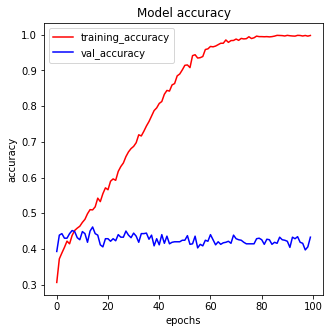

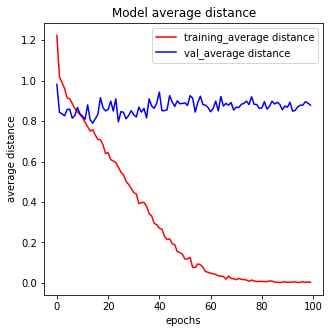

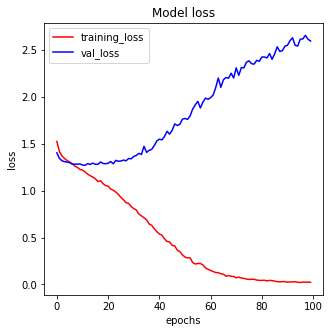

In [ ]:
epochs = stats['epoch']
plot_stats(epochs, 'accuracy', stats['train_acc'], stats['valid_acc'])
plot_stats(epochs, 'average distance', stats['train_avg_distance'], stats['valid_avg_distance'])
plot_stats(epochs, 'loss', stats['train_loss'], stats['valid_loss'])


[[33 34 19  7  7]
 [35 38 16  4  7]
 [22 16 26 19 17]
 [10 12 12 31 35]
 [ 2  2 11 20 65]]


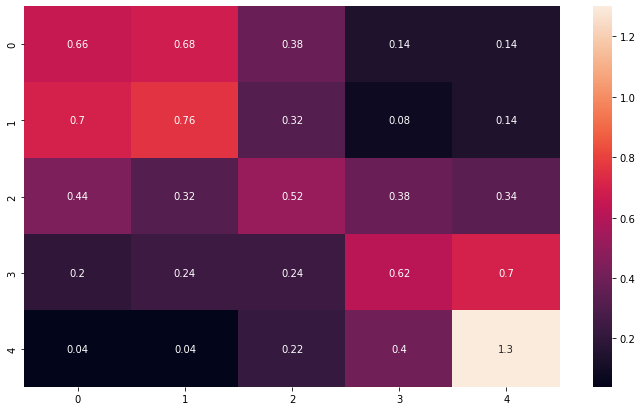

In [ ]:
# plot confusion matrix 
import seaborn as sn
testing_output = VGG16.model_testing()
cf_matrix = testing_output[4]
print(cf_matrix)
classes = [0, 1, 2, 3, 4]
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot = True)

In [ ]:
# download trained model
from google.colab import files

# Jimin's path below
path_to_model = '/content/gdrive/MyDrive/CS4641_dataset/final_VGG16_normalized.pth'

torch.save(VGG16, path_to_model)


In [ ]:
model = torch.load(path_to_model)
model.model_testing()

[0.386, 0.23342738176245054, 0.46485, 0.942, array([[33, 34, 19,  7,  7],
        [35, 38, 16,  4,  7],
        [22, 16, 26, 19, 17],
        [10, 12, 12, 31, 35],
        [ 2,  2, 11, 20, 65]]), 2.947535991668701]